# Toggle-Frame Example Problem: Single Drive

This notebook illustrates the effectiveness of the toggling-frame robustness objective for both multiplicative and additive errors for a single pauli X drive and Hadamard as the unitary goal. It's strucuted as follows:
* Imports
* Problem Setup 
* Problem Solve
* Plot fidelity swept over additive & multiplicative error 
* Save trjaectories to file

## Imports

In [136]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate();
Pkg.develop(path="../../QuantumCollocation.jl")
using PiccoloQuantumObjects
using QuantumCollocation
using ForwardDiff
using LinearAlgebra
using Plots
using SparseArrays
using Statistics
using CairoMakie
using NamedTrajectories
using TrajectoryIndexingUtils
using Random

  Activating project at `~/Documents/GitHub/robust_control_sam/src`
Precompiling project...
           ✗ QuantumCollocation
  0 dependencies successfully precompiled in 6 seconds. 575 already precompiled.

The following 1 direct dependency failed to precompile:

QuantumCollocation 

Failed to precompile QuantumCollocation [0dc23a59-5ffb-49af-b6bd-932a8ae77adf] to "/Users/andrewkamen/.julia/compiled/v1.11/QuantumCollocation/jl_Fu08Ew".
ERROR: LoadError: ArgumentError: Package QuantumCollocation does not have Piccolissimo in its dependencies:
- You may have a partially installed environment. Try `Pkg.instantiate()`
  to ensure all packages in the environment are installed.
- Or, if you have QuantumCollocation checked out for development and have
  added Piccolissimo as a dependency but haven't updated your primary
  environment's manifest file, try `Pkg.resolve()`.
- Otherwise you may need to report an issue with QuantumCollocation
Stacktrace:
  [1] macro expansion
    @ ./loading.jl:229

Pkg.Resolve.ResolverError: Unsatisfiable requirements detected for package [38;5;12mPiccolissimo [8458e44f][39m:
 [38;5;12mPiccolissimo [8458e44f][39m log:
 ├─[38;5;12mPiccolissimo [8458e44f][39m has no known versions!
 └─restricted to versions [38;5;12m*[39m by [38;5;10mQuantumCollocation [0dc23a59][39m — no versions left
   └─[38;5;10mQuantumCollocation [0dc23a59][39m log:
     ├─possible versions are: [38;5;10m0.8.1[39m or uninstalled
     └─[38;5;10mQuantumCollocation [0dc23a59][39m is fixed to version [38;5;10m0.8.1[39m

## Problem Setup

In [ ]:
# Problem parameters
T = 40
Δt = 0.2
U_goal = exp(- 1.0im * π * PAULIS.Y / 4)
Δ = 0.2 # detuning
H_drift = Δ * PAULIS.Z
H_drive = [PAULIS.X, PAULIS.Y]
a_bound = 1.0
dda_bound = 4.0
piccolo_opts = PiccoloOptions(verbose=false)
pretty_print(X::AbstractMatrix) = Base.show(stdout, "text/plain", X);
sys = QuantumSystem(H_drift, H_drive)

QuantumSystem: levels = 2, n_drives = 2

In [81]:
sys.H.H_drives

2-element Vector{SparseMatrixCSC{ComplexF64, Int64}}:
 sparse([2, 1], [1, 2], ComplexF64[1.0 + 0.0im, 1.0 + 0.0im], 2, 2)
 sparse([2, 1], [1, 2], ComplexF64[0.0 + 1.0im, 0.0 - 1.0im], 2, 2)

In [92]:
# additive error Hamiltonian
Hₑ_add = a -> PAULIS.Z

# multiplicative error Hamiltonian
# X_drive = sys.H.H_drives[1]
# Hₑ_mult = a -> a[1] * X_drive

# no robustness
default = UnitarySmoothPulseProblem(sys, U_goal, T, Δt)
solve!(default, max_iter=200, print_level=5)

# additive robustness
add_prob = UnitarySmoothPulseProblem(
            sys, U_goal, T, Δt;
            piccolo_options=piccolo_opts,
            activate_rob_loss=true,
            H_err=Hₑ_add,
            Q_t=1.0
        )
solve!(add_prob, max_iter=200, print_level=5)

# multiplicative robustness
# mult_prob = UnitarySmoothPulseProblem(
#     sys, U_goal, T, Δt;
#     piccolo_options=piccolo_opts,
#     activate_rob_loss=true,
#     H_err=Hₑ_mult,
#     Q_t=1.0
# )
# solve!(mult_prob, max_iter=200, print_level=5)

    constructing UnitarySmoothPulseProblem...
	using integrator: typeof(UnitaryIntegrator)
	control derivative names: [:da, :dda]
	applying timesteps_all_equal constraint: Δt
    initializing optimizer...
        applying constraint: timesteps all equal constraint
        applying constraint: initial value of Ũ⃗
        applying constraint: initial value of a
        applying constraint: final value of a
        applying constraint: bounds on a
        applying constraint: bounds on da
        applying constraint: bounds on dda
        applying constraint: bounds on Δt
This is Ipopt version 3.14.17, running with linear solver MUMPS 5.8.0.

Number of nonzeros in equality constraint Jacobian...:     4362
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2189

Total number of variables............................:      588
                     variables with only lower bounds:        0
                variables with 

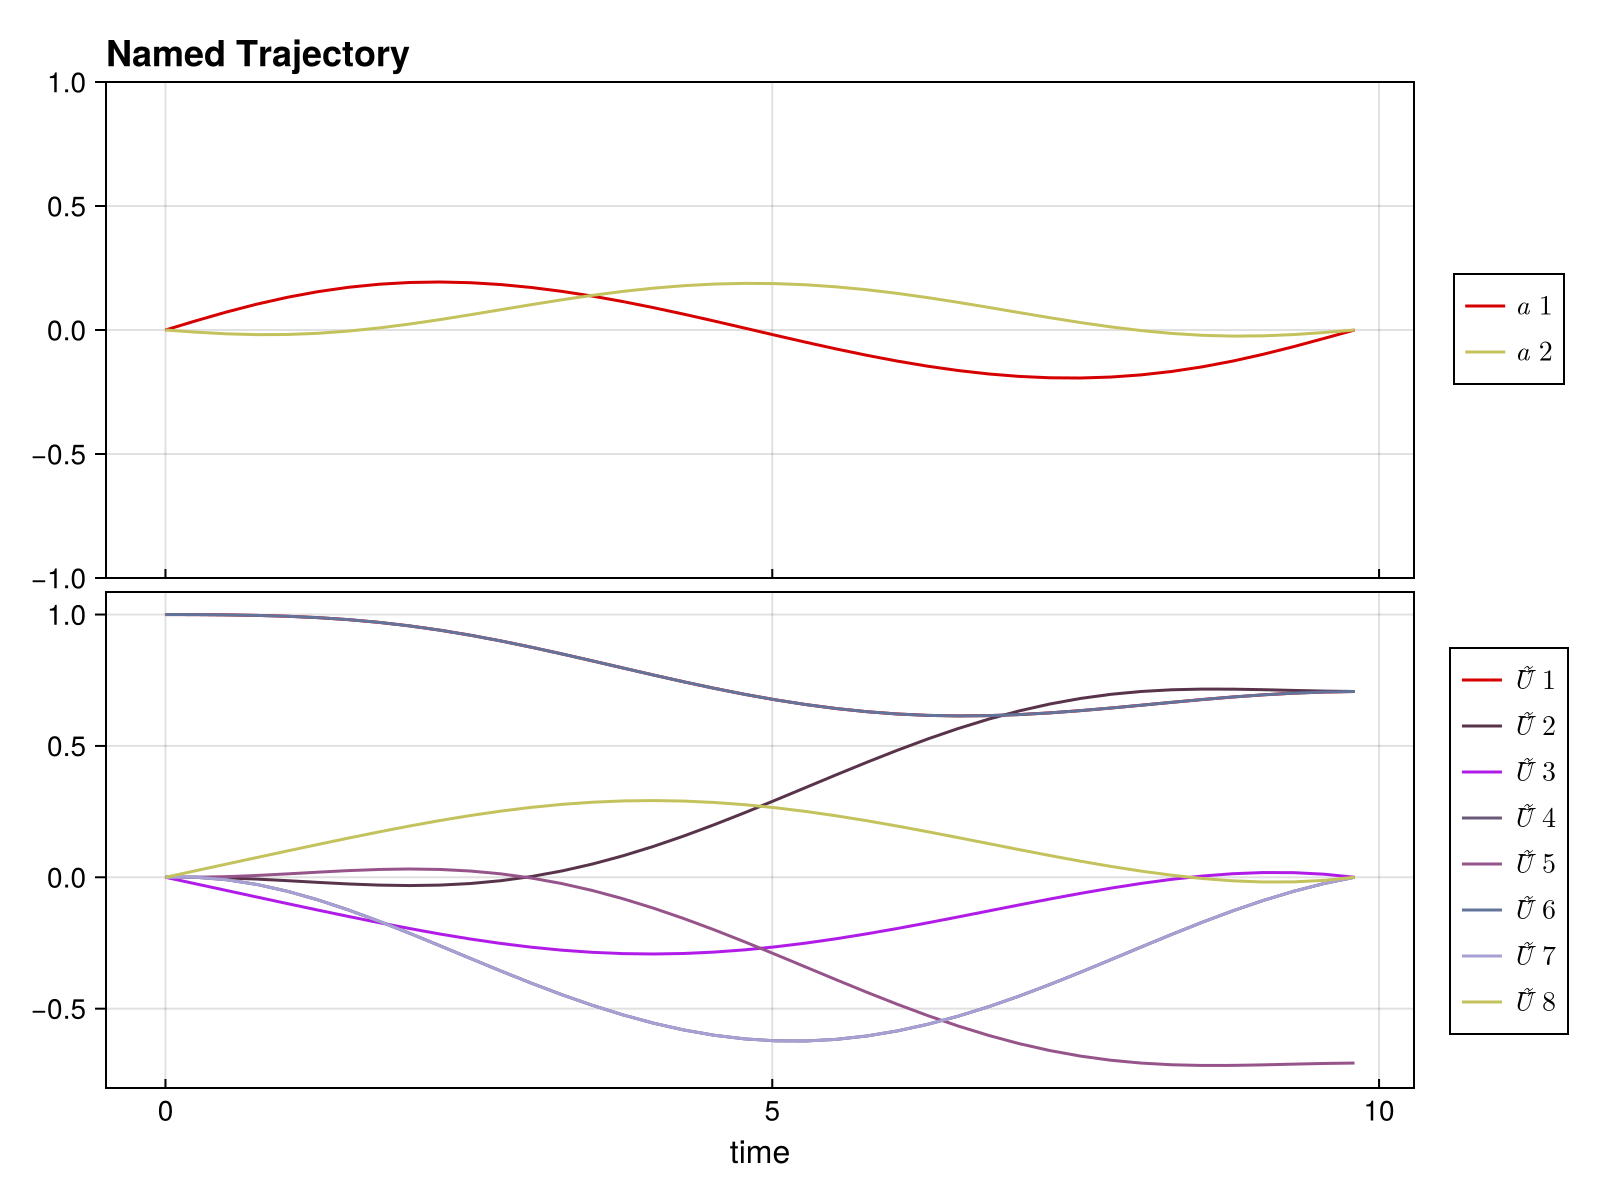

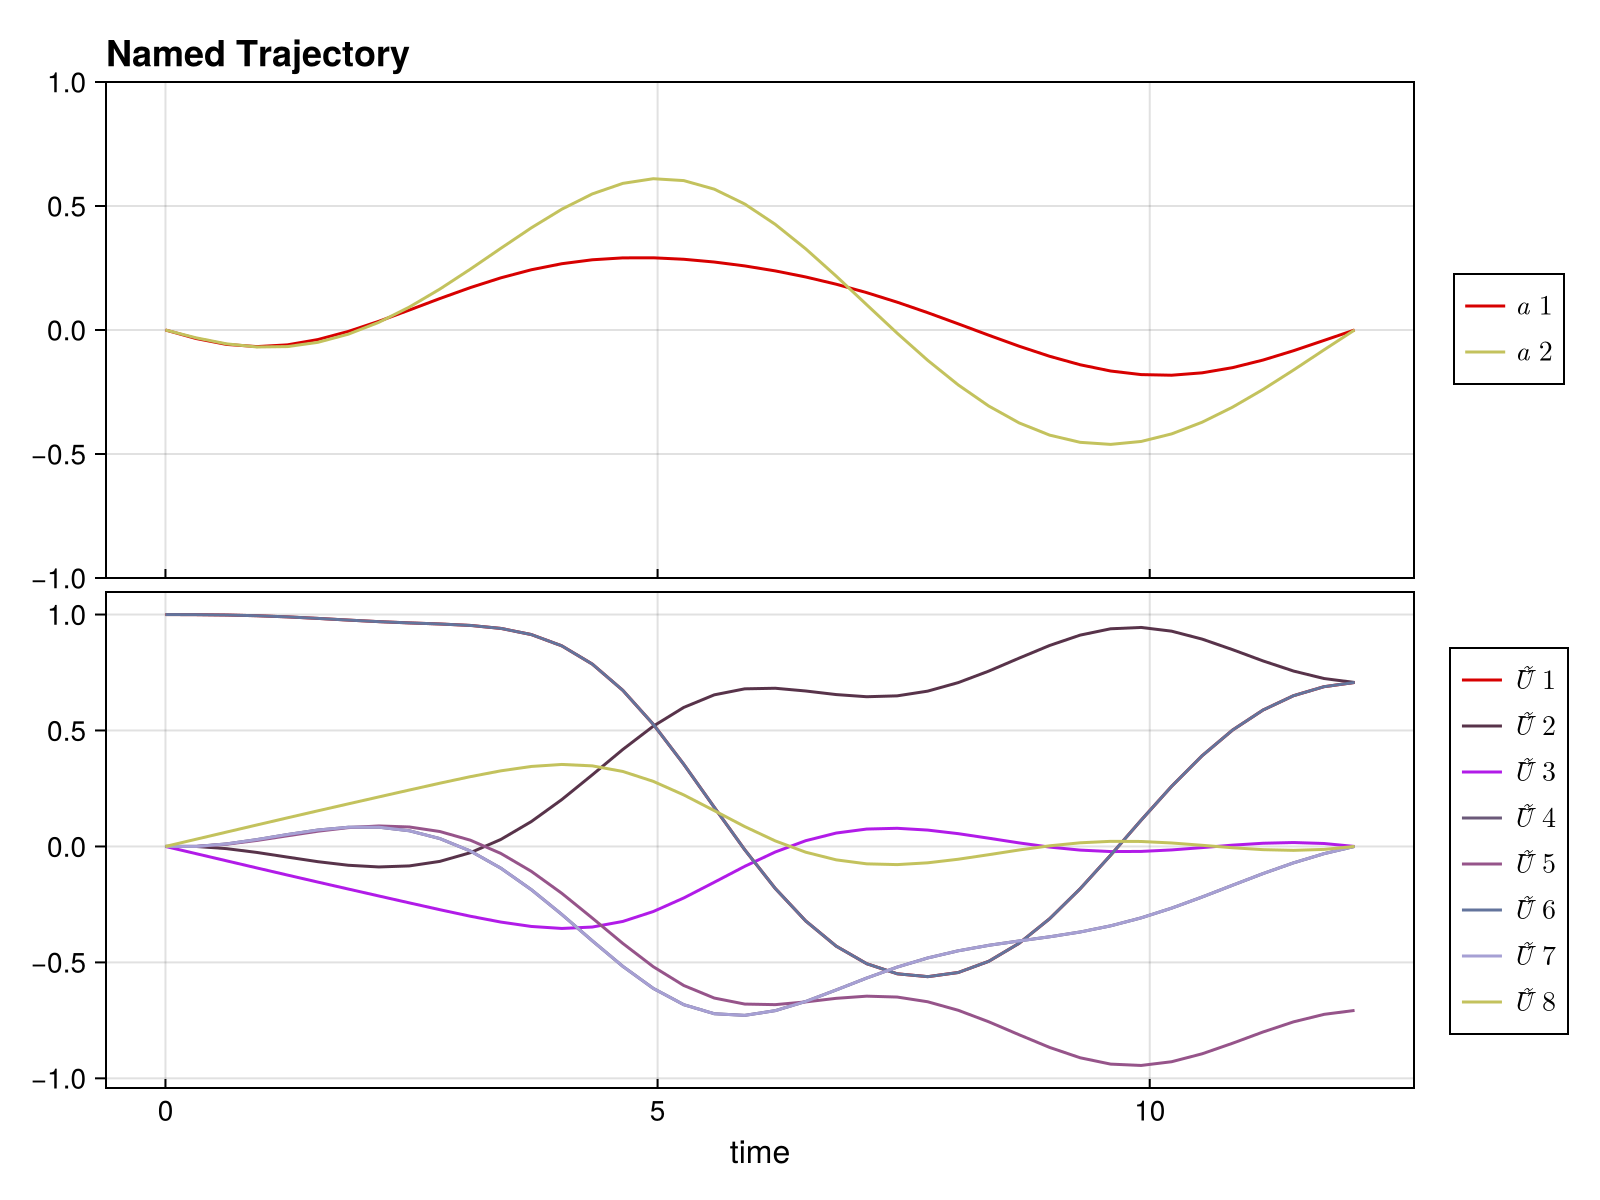

CairoMakie.Screen{IMAGE}


In [93]:
p1 = CairoMakie.plot(default.trajectory, [:a, :Ũ⃗])
p2 = CairoMakie.plot(add_prob.trajectory, [:a, :Ũ⃗])
#p3 = CairoMakie.plot(mult_prob.trajectory, [:a, :Ũ⃗])

display(p1)
display(p2)
#display(p3)

#### Plotting

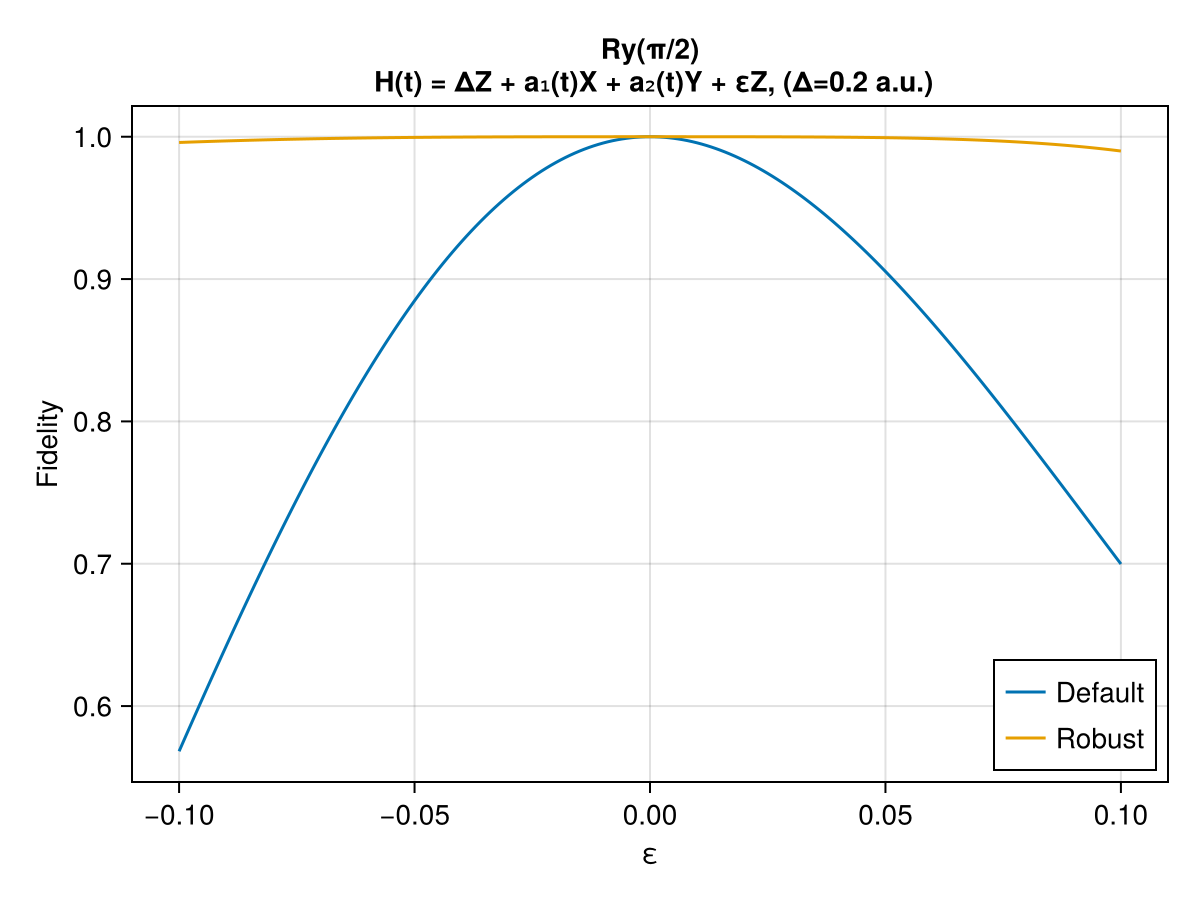

In [132]:
H_drive_add = H_drive

f = Figure()
ax1 = Axis(f[1, 1],
    title = "Ry(π/2)\n H(t) = ΔZ + a₁(t)X + a₂(t)Y + εZ, (Δ=0.2 a.u.)",
    xlabel = "ε",
    ylabel = "Fidelity"
)
#ax2 = Axis(f[2, 1], title="multiplicative")

colors = Makie.wong_colors()

εs = -.1:0.001:.1

# default case (smooth, non-variational, w/o toggling obj)

ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(ε * PAULIS.Z + H_drift, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="Default", color=colors[1], linestyle=:solid)

# ys = [unitary_rollout_fidelity(default.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="default", color=colors[1], linestyle=:solid)

# toggling obj

# (add)
ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(ε * PAULIS.Z + H_drift, [PAULIS.X, PAULIS.Y])) for ε in εs]
lines!(ax1, εs, ys, label="Robust", color=colors[2], linestyle=:solid)

# ys = [unitary_rollout_fidelity(add_prob.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="add toggle", color=colors[2], linestyle=:solid)

# (mult)
# ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
# lines!(ax1, εs, ys, label="mult toggle", color=colors[6], linestyle=:solid)

# ys = [unitary_rollout_fidelity(mult_prob.trajectory, QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
# lines!(ax2, εs, ys, label="mult toggle", color=colors[6], linestyle=:solid)

# # (both)
# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem(ε * PAULIS.X, [PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax1, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

# ys = [unitary_rollout_fidelity(both_prob.trajectory, QuantumSystem([(1 + ε) * PAULIS.X, PAULIS.Y])) for ε in εs]
# lines!(ax2, εs, ys, label="both toggle", color=colors[4], linestyle=:solid)

axislegend(ax1; position = :rb, tellwidth = false, tellheight = false)
#Legend(f[2,2], ax2, position=:lb)

f


In [133]:
# ---------- Summary statistics ----------

# Helper to avoid division-by-zero in % improvement
safe_improvement(base, rob) = base == 0 ? 0.0 : (base - rob) / base * 100

# Build infidelity arrays over the same ε grid you defined earlier
# (Additive model: H = ε X + H_drift, drive = X)
additive_base_infids  = [1 - unitary_rollout_fidelity(default.trajectory,
                            QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
additive_robust_infids = [1 - unitary_rollout_fidelity(add_prob.trajectory,
                            QuantumSystem(ε * PAULIS.X + H_drift, [PAULIS.X])) for ε in εs]
additive_improvements = [safe_improvement(additive_base_infids[i], additive_robust_infids[i])
                         for i in eachindex(additive_base_infids)]

# (Multiplicative model: H = H_drift, drive = (1+ε) X)
mult_base_infids  = [1 - unitary_rollout_fidelity(default.trajectory,
                        QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
mult_robust_infids = [1 - unitary_rollout_fidelity(mult_prob.trajectory,
                        QuantumSystem(H_drift, [(1 + ε) * PAULIS.X])) for ε in εs]
mult_improvements = [safe_improvement(mult_base_infids[i], mult_robust_infids[i])
                     for i in eachindex(mult_base_infids)]

error_magnitudes = collect(εs)

println("\nAdditive Error Results:")
println("Average base infidelity: $(round(mean(additive_base_infids), digits=4))")
println("Average robust infidelity: $(round(mean(additive_robust_infids), digits=4))")
println("Average improvement: $(round(mean(additive_improvements), digits=2))%")
println("Max improvement: $(round(maximum(additive_improvements), digits=2))%")

println("\nMultiplicative Error Results:")
println("Average base infidelity: $(round(mean(mult_base_infids), digits=4))")
println("Average robust infidelity: $(round(mean(mult_robust_infids), digits=4))")
println("Average improvement: $(round(mean(mult_improvements), digits=2))%")
println("Max improvement: $(round(maximum(mult_improvements), digits=2))%")

# Which error type benefits more?
avg_add_improvement = mean(additive_improvements)
avg_mult_improvement = mean(mult_improvements)

println("\nComparison:")
if avg_add_improvement > avg_mult_improvement
    println(" Additive errors benefit more from robust optimization")
    println("  Difference: $(round(avg_add_improvement - avg_mult_improvement, digits=2))% better")
elseif avg_mult_improvement > avg_add_improvement
    println(" Multiplicative errors benefit more from robust optimization")
    println("  Difference: $(round(avg_mult_improvement - avg_add_improvement, digits=2))% better")
else
    println(" Tie: both see the same average improvement")
end

println("\n Results Table:")
println("Error ε  | Add Base | Add Rob  | Add Imp% | Mult Base| Mult Rob | Mult Imp%")
println("-" ^ 75)
for i in eachindex(error_magnitudes)
    println("$(lpad(round(error_magnitudes[i], digits=4), 7)) | " *
            "$(lpad(round(additive_base_infids[i],  digits=4), 8)) | " *
            "$(lpad(round(additive_robust_infids[i], digits=4), 8)) | " *
            "$(lpad(round(additive_improvements[i], digits=1), 8)) | " *
            "$(lpad(round(mult_base_infids[i],     digits=4), 9)) | " *
            "$(lpad(round(mult_robust_infids[i],    digits=4), 8)) | " *
            "$(lpad(round(mult_improvements[i],    digits=1), 9))")
end


UndefVarError: UndefVarError: `mult_prob` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

Save Trajectory

In [9]:
using JLD2
using Dates

# Collect just the three trajectories from your problems
default_traj   = default.trajectory
add_traj       = add_prob.trajectory
mult_traj      = mult_prob.trajectory

# Optional: store both fidelity and infidelity traces used above
fid_traces = Dict(
    "εs" => error_magnitudes,
    # Additive
    "additive_base_infids"   => additive_base_infids,
    "additive_robust_infids" => additive_robust_infids,
    "additive_improvements"  => additive_improvements,
    # Multiplicative
    "mult_base_infids"       => mult_base_infids,
    "mult_robust_infids"     => mult_robust_infids,
    "mult_improvements"      => mult_improvements,
)

# Minimal metadata to reconstruct the setup
meta = Dict(
    "T"         => T,
    "Δt"        => Δt,
    "U_goal"    => U_goal,
    "a_bound"   => a_bound,
    "dda_bound" => dda_bound,
    "H_drift"   => H_drift,
    "H_drive"   => H_drive,
    "robust_opts" => Dict("Q_t" => 1.0,
                          "Hₑ_add" => "ε * X added to drift",
                          "Hₑ_mult" => "(1+ε) scaling of X drive")
)

# Save into artifacts/ with timestamped filename
mkpath("artifacts")
timestamp = Dates.format(Dates.now(), "yyyymmdd_HHMMSS")
outfile = joinpath("artifacts", "single_run_trajectories_$(timestamp).jld2")

@info "Saving trajectories and traces to $outfile"
@save outfile default_traj add_traj mult_traj fid_traces meta
@info "Done. Saved keys: default_traj, add_traj, mult_traj, fid_traces, meta"


UndefVarError: UndefVarError: `mult_prob` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [95]:
add_traj = add_prob.trajectory
default_traj = default.trajectory

function SpaceCurve(traj::NamedTrajectory, U_goal::AbstractMatrix{<:Number}, H_err::AbstractMatrix{<:Number})
    T = traj.T
    first_order_terms = Vector{Matrix{ComplexF64}}(undef, T)
    first_order_integral = zeros(ComplexF64, size(U_goal))

    for i in 1:T
        U = iso_vec_to_operator(traj.Ũ⃗[:, i])
        first_order_integral += U' * Hₑ * U
        first_order_terms[i] = first_order_integral
    end
    space_curve = [[real(tr(PAULIS.X * first_order_terms[t])),
                    real(tr(PAULIS.Y * first_order_terms[t])),
                    real(tr(PAULIS.Z * first_order_terms[t]))] for t in 1:T] 
    return space_curve
end

SpaceCurve (generic function with 1 method)

In [96]:
add_curve = SpaceCurve(add_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

40-element Vector{Vector{Float64}}:
 [0.0, 0.0, 2.0]
 [0.0, 0.0, 4.0]
 [0.011546694779518002, 0.03666566352979276, 5.999630541614523]
 [0.04754422196662353, 0.14360664377694993, 7.996444955820357]
 [0.12032008368301692, 0.35011220181578623, 9.984423609742604]
 [0.2401035981683252, 0.6803650296066439, 11.953328122255513]
 [0.41390139236658435, 1.1529753024499416, 13.888898802115799]
 [0.6447706396274904, 1.7807946648582134, 15.773717689662945]
 [0.9314854225158549, 2.571009702742444, 17.588477956798776]
 [1.268566681713393, 3.525499413664737, 19.31339117677284]
 ⋮
 [-7.419943416820469, 39.198371103272706, 25.49133885473697]
 [-9.247526273140831, 39.960033807051836, 25.208830750506714]
 [-11.141314929402018, 40.56195979332525, 24.982446933803256]
 [-13.082530380043474, 41.012424186400466, 24.812846212217934]
 [-15.054502127877914, 41.325149561929074, 24.69652654387562]
 [-17.043817989476494, 41.51925866703029, 24.62621254733804]
 [-19.041033002113657, 41.61893508871212, 24.59161768850842

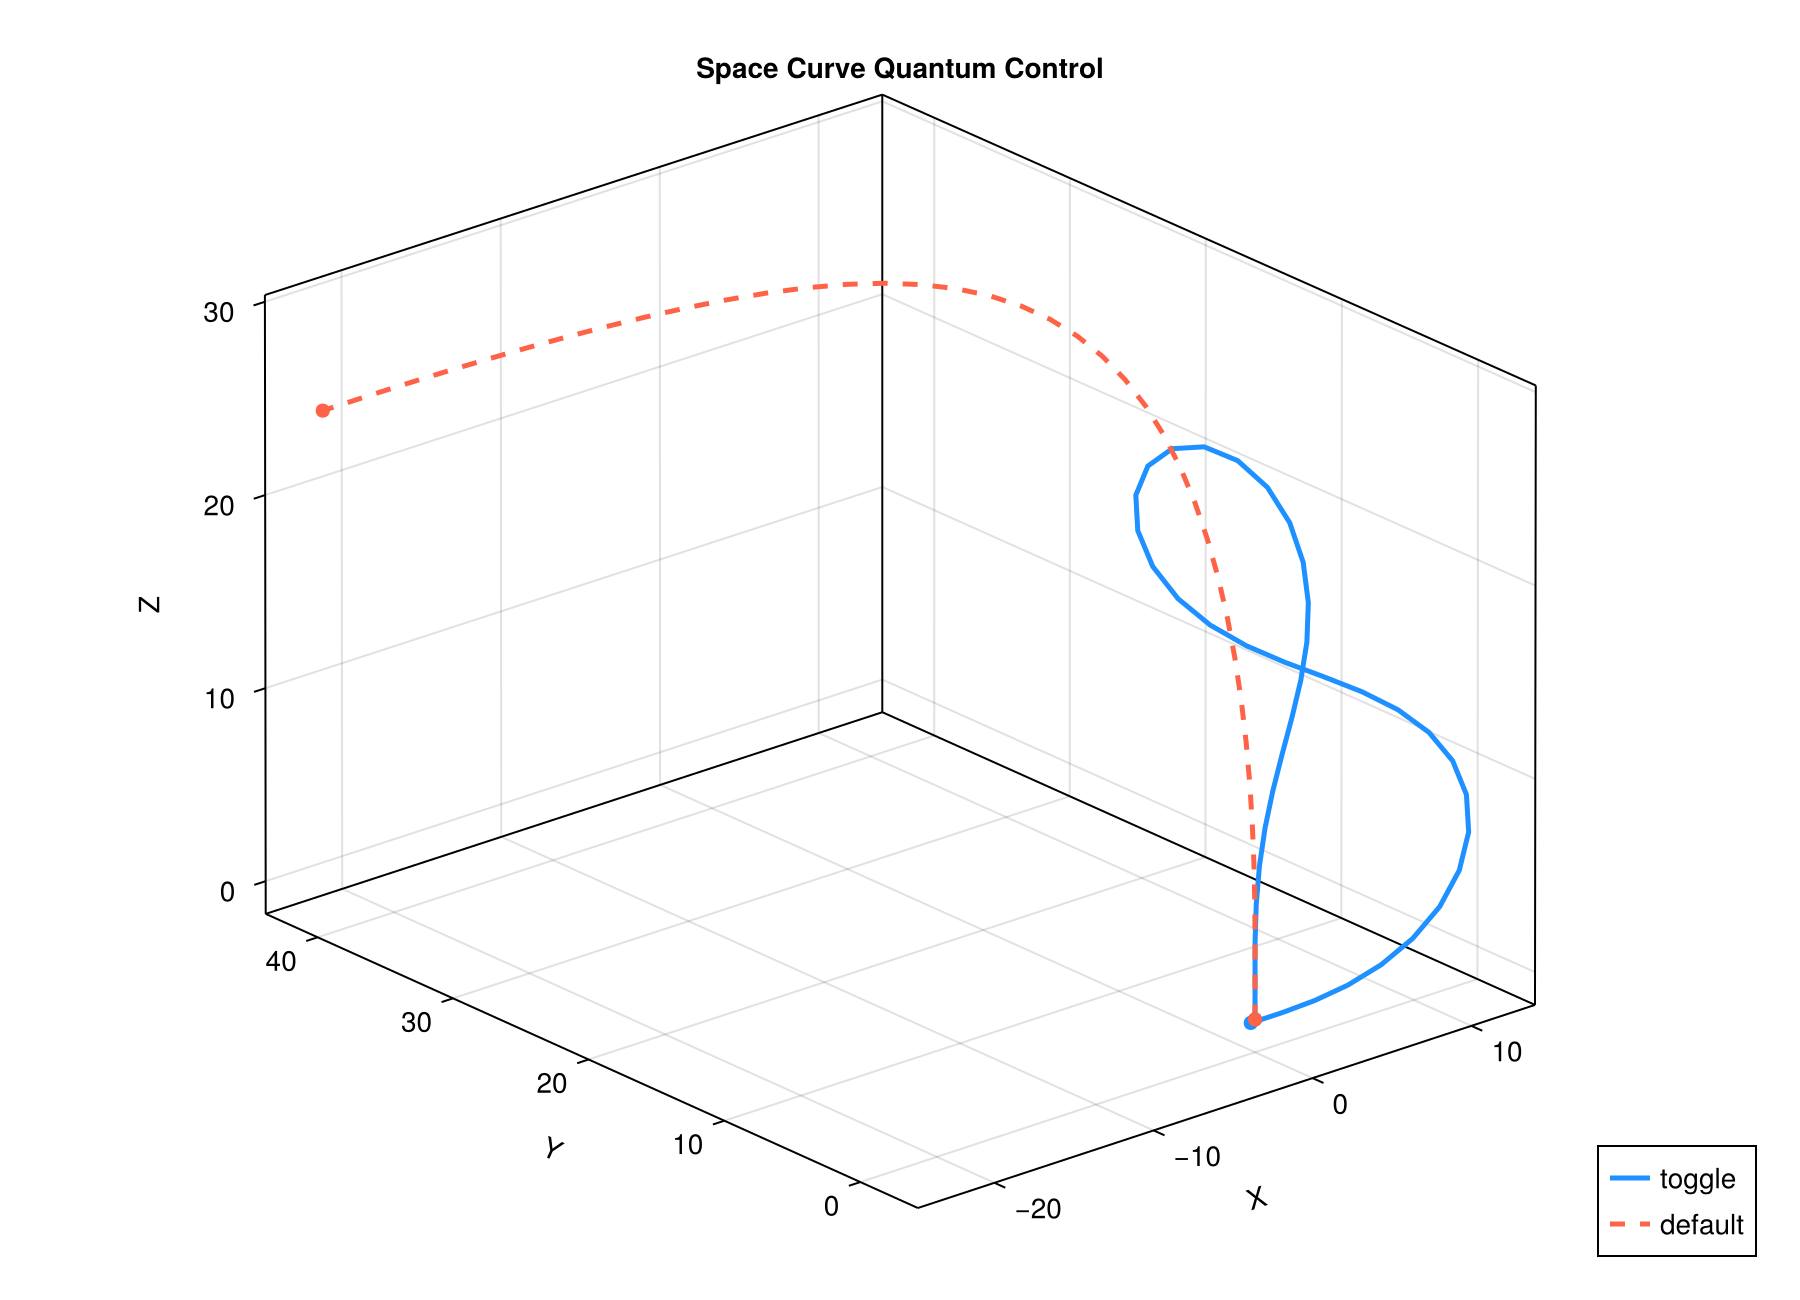

CairoMakie.Screen{IMAGE}


In [135]:
using CairoMakie
const CM = CairoMakie

function to_xyz(curve)
    if curve isa AbstractMatrix
        M = Float64.(real.(curve))
        if size(M, 2) == 3
            x, y, z = M[:, 1], M[:, 2], M[:, 3]
        elseif size(M, 1) == 3
            x, y, z = M[1, :], M[2, :], M[3, :]
        else
            error("Matrix curve must be T×3 or 3×T, got $(size(M))")
        end
    else
        x = Float64.(real.(getindex.(curve, 1)))
        y = Float64.(real.(getindex.(curve, 2)))
        z = Float64.(real.(getindex.(curve, 3)))
    end
    mask = isfinite.(x) .& isfinite.(y) .& isfinite.(z)
    return x[mask], y[mask], z[mask]
end

add_curve     = SpaceCurve(add_traj, U_goal, Hₑ)
default_curve = SpaceCurve(default_traj, U_goal, Hₑ)

x1, y1, z1 = to_xyz(add_curve)
x2, y2, z2 = to_xyz(default_curve)

pushfirst!(x1, 0.0)
pushfirst!(y1, 0.0)
pushfirst!(z1, 0.0)
pushfirst!(x2, 0.0)
pushfirst!(y2, 0.0)
pushfirst!(z2, 0.0)

f  = CM.Figure(size = (900, 650))
ax = CM.Axis3(f[1, 1];
    xlabel = "X", ylabel = "Y", zlabel = "Z",
    title = "Space Curve Quantum Control", aspect = :data
)

CM.lines!(ax, x1, y1, z1; linewidth = 2.5, color = :dodgerblue, label = "toggle")
CM.lines!(ax, x2, y2, z2; linewidth = 2.5, linestyle = :dash, color = :tomato, label = "default")

CM.scatter!(ax, [x1[1]],  [y1[1]],  [z1[1]];  markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x1[end]],[y1[end]],[z1[end]]; markersize = 10, color = :dodgerblue)
CM.scatter!(ax, [x2[1]],  [y2[1]],  [z2[1]];  markersize = 10, color = :tomato)
CM.scatter!(ax, [x2[end]],[y2[end]],[z2[end]]; markersize = 10, color = :tomato)

CM.axislegend(ax; position = :rb)

display(f)


In [113]:
ket_0 = [1/sqrt(2),-1.0/sqrt(2)]

rho_0 = ket_0 * ket_0'

expect_val_x = [real(tr(PAULIS.X * iso_vec_to_operator(add_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(add_traj.Ũ⃗[:, t])')) for t in 1:add_traj.T]
expect_val_y = [real(tr(PAULIS.Y * iso_vec_to_operator(add_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(add_traj.Ũ⃗[:, t])')) for t in 1:add_traj.T]
expect_val_z = [real(tr(PAULIS.Z * iso_vec_to_operator(add_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(add_traj.Ũ⃗[:, t])')) for t in 1:add_traj.T]
expect_val_x_1 = [real(tr(PAULIS.X * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_y_1 = [real(tr(PAULIS.Y * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]
expect_val_z_1 = [real(tr(PAULIS.Z * iso_vec_to_operator(default_traj.Ũ⃗[:, t]) * rho_0 * iso_vec_to_operator(default_traj.Ũ⃗[:, t])')) for t in 1:default_traj.T]


40-element Vector{Float64}:
  0.0
  0.0
 -0.005773347389758932
 -0.01799876359355279
 -0.03638793085819669
 -0.05989175724265405
 -0.08689889709912957
 -0.11543462363045304
 -0.1433573914441822
 -0.16854062959876892
  ⋮
  0.8709149226929117
  0.9137914281601812
  0.9468943281305929
  0.9706077253207278
  0.9859858739172201
  0.9946579307992908
  0.9986075063185808
  0.9998415804544981
  0.99999999994586

┌ Warning: Found `resolution` in the theme when creating a `Scene`. The `resolution` keyword for `Scene`s and `Figure`s has been deprecated. Use `Figure(; size = ...` or `Scene(; size = ...)` instead, which better reflects that this is a unitless size and not a pixel resolution. The key could also come from `set_theme!` calls or related theming functions.
└ @ Makie /Users/andrewkamen/.julia/packages/Makie/FUAHr/src/scenes.jl:238
┌ Warning: `shading = true` is not valid. Use `Makie.automatic`, `NoShading`, `FastShading` or `MultiLightShading`. Defaulting to `MakieCore.Automatic()`.
└ @ Makie /Users/andrewkamen/.julia/packages/Makie/FUAHr/src/lighting.jl:243


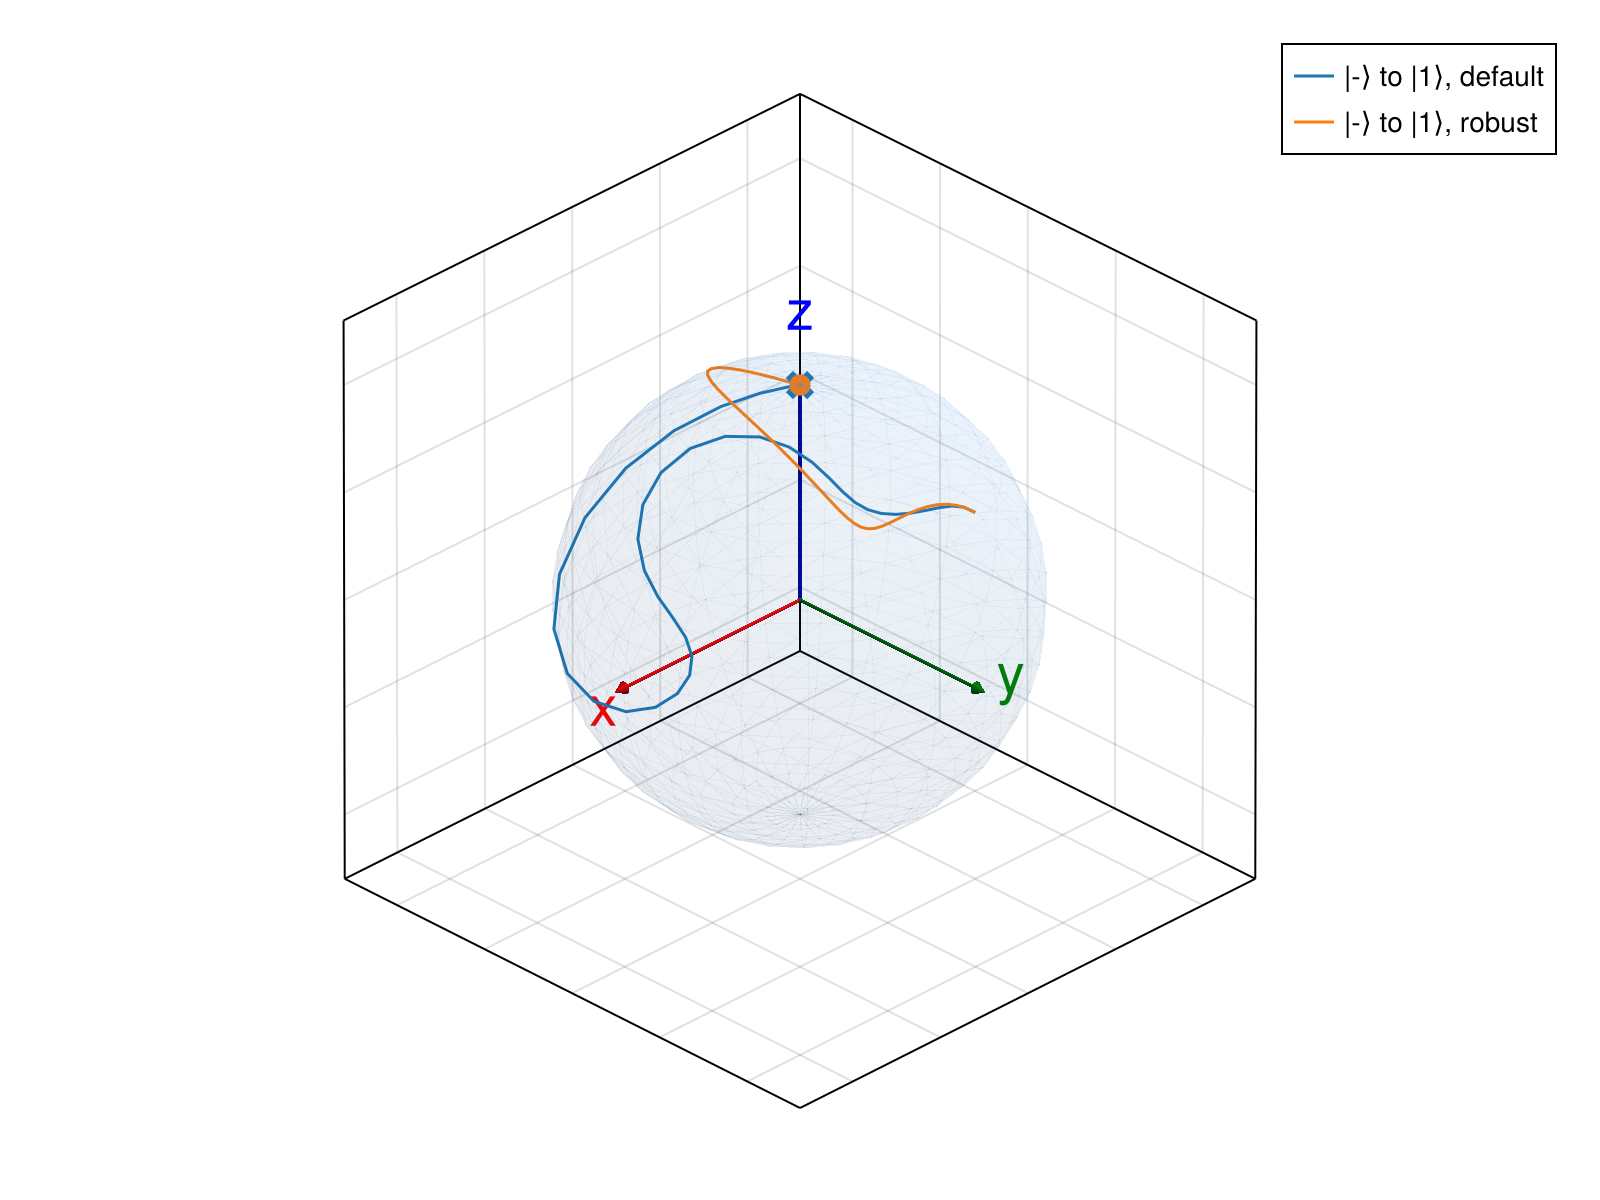

In [131]:
using CairoMakie          # Makie backend + plotting API
using GeometryBasics      # for Point3f/Vec3f

f  = CairoMakie.Figure(resolution = (800, 600))
ax = CairoMakie.Axis3(f[1, 1];
    aspect = :equal
)

palette = to_colormap(:tab10)
styles  = (:solid, :dash, :dot, :dashdot)

# --- axis arrows -------------------------------------------------------------
origins = [Point3f(0,0,0), Point3f(0,0,0), Point3f(0,0,0)]
dirs    = [Vec3f(1.0,0,0), Vec3f(0,1.0,0), Vec3f(0,0,1.0)]  # arrows unchanged

CairoMakie.arrows!(ax, origins, dirs;
    color = [:red, :green, :blue],
    arrowsize = 0.05,
    linewidth = 0.01
)

# Labels placed further than tip, font bigger
CairoMakie.text!(ax, "x", position = Point3f(1.2, 0, 0), align = (:left, :center),  color = :red,   fontsize = 28)
CairoMakie.text!(ax, "y", position = Point3f(0, 1.2, 0), align = (:center, :bottom), color = :green, fontsize = 28)
CairoMakie.text!(ax, "z", position = Point3f(0, 0, 1.2), align = (:center, :bottom), color = :blue,  fontsize = 28)

# --- trajectory --------------------------------------------------------------
CairoMakie.lines!(ax, real.(expect_val_x), real.(expect_val_y), real.(expect_val_z);
    color     = palette[1],
    linestyle = styles[1],
    label     = "|-⟩ to |1⟩, default",
    linewidth = 1.5
)

CairoMakie.lines!(ax, real.(expect_val_x_1), real.(expect_val_y_1), real.(expect_val_z_1);
    color     = palette[2],
    linestyle = styles[1],
    label     = "|-⟩ to |1⟩, robust",
    linewidth = 1.5
)

CairoMakie.scatter!(ax, [real(expect_val_x[end])], [real(expect_val_y[end])], [real(expect_val_z[end])];
    color = palette[1], markersize = 20, marker = :xcross)

CairoMakie.scatter!(ax, [real(expect_val_x_1[end])], [real(expect_val_y_1[end])], [real(expect_val_z_1[end])];
    color = palette[2], markersize = 15, marker = :circle)

# --- translucent unit sphere -------------------------------------------------
CairoMakie.mesh!(ax, Sphere(Point3f(0,0,0), 1f0);
    color = (0.2, 0.6, 1.0, 0.05),
    transparency = true,
    shading = true
)

# --- cosmetics ---------------------------------------------------------------
CairoMakie.xlims!(ax, -1.3, 1.3)
CairoMakie.ylims!(ax, -1.3, 1.3)
CairoMakie.zlims!(ax, -1.3, 1.3)

ax.azimuth[]   =  π/4
ax.elevation[] =  π/6

CairoMakie.axislegend(ax; position = :rt)
CairoMakie.hidexdecorations!(ax, grid = false)
CairoMakie.hideydecorations!(ax, grid = false)
CairoMakie.hidezdecorations!(ax, grid = false)

# CairoMakie.save("exact_1.png", f)
f

In [11]:
# using JLD2
# @load "artifacts/trajectories_YYYYMMDD_HHMMSS.jld2" default_trajs add_traj mult_traj fid_traces meta
